In [1]:
# RealSense Setup #
import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils_ur5 import *
from Pose_Estimation_Class import *

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, 30)

# Start streaming
cfg = pipeline.start(config)
align = rs.align(rs.stream.color)

# Get camera instrinsics
color_profile = cfg.get_stream(rs.stream.color, 0)
intr = color_profile.as_video_stream_profile().get_intrinsics()

fx, fy, height, width = intr.fx, intr.fy, intr.height, intr.width
cx, cy = intr.ppx, intr.ppy
K_rs = np.array([[fx, 0, cx],
               [0, fy, cy],
               [0, 0, 1]])
D_rs = 0

def get_frames(pipeline):
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    if not depth_frame or not color_frame:
        return None, None

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data()) * 0.001
    color_image = np.asanyarray(color_frame.get_data())
    return color_image, depth_image

In [1]:
# moveit planner
import rospy
import moveit_commander
import moveit_msgs.msg
import geometry_msgs.msg
from std_msgs.msg import String

# robotiq gripper
import pyRobotiqGripper

try:
    from math import pi, tau, dist, fabs, cos
except:
    from math import pi, fabs, cos, sqrt

    tau = 2.0 * pi

    def dist(p, q):
        return sqrt(sum((p_i - q_i) ** 2.0 for p_i, q_i in zip(p, q)))

from std_msgs.msg import String
from moveit_commander.conversions import pose_to_list

Failed to import pyassimp, see https://github.com/moveit/moveit/issues/86 for more info


In [4]:
ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
ROBOT_INIT_POS = [0.0, -0.3, 0.65]
ROBOT_INIT_ROTATION = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

# init node
rospy.init_node("test", anonymous=True)
robot = moveit_commander.RobotCommander()
scene = moveit_commander.PlanningSceneInterface()
move_group = moveit_commander.MoveGroupCommander("manipulator")

# init gripper
gripper_controller = pyRobotiqGripper.RobotiqGripper()
gripper_controller.activate()

# eef to realsense offset
T_eef_to_rs = np.load('rs_extrinsic.npy')

[ WARN] [1719825326.376107783]: IK plugin for group 'manipulator' relies on deprecated API. Please implement initialize(RobotModel, ...).


Exception: No gripper detected

In [3]:
def get_joint_states():
    return move_group.get_current_joint_values()

def get_eef_pose():
    pose = move_group.get_current_pose().pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

def get_view(goal_pos=None, quat=[1, 0, 0, 0], grasp=0.0, show_img=False):
    # quat: xyzw
    if goal_pos is not None:
        pose_goal = geometry_msgs.msg.Pose()
        pose_goal.orientation.x = quat[0]
        pose_goal.orientation.y = quat[1]
        pose_goal.orientation.z = quat[2]
        pose_goal.orientation.w = quat[3]
        pose_goal.position.x = goal_pos[0]
        pose_goal.position.y = goal_pos[1]
        pose_goal.position.z = goal_pos[2]
        move_group.set_pose_target(pose_goal)
        res = move_group.plan()

        # check success
        if res[0] is False:
            print("Failed planning to the goal")
            return None, None
        else:
            # move to the view
            move_group.execute(res[1], wait=True)
    # gripper control
    if grasp > 0.0:
        gripper_controller.close()
        # suction gripper grasping
        # gripper_controller.grasp()
    else:
        gripper_controller.open()
    
    rospy.sleep(0.5)
    if show_img:
        color, depth = get_frames(pipeline)
        # plt.imshow(color)
        # plt.show()
        return color, depth
    return None, None

In [4]:
import sys
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

sys.path.append('/home/ur-plusle/Desktop/contact_graspnet/contact_graspnet')
import config_utils
from data import regularize_pc_point_count, depth2pc, load_available_input_data

from PIL import Image
from contact_grasp_estimator import GraspEstimator
from visualization_utils import visualize_grasps, show_image

from mayavi import mlab
mlab.init_notebook()

2024-06-25 14:14:33.274254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-06-25 14:14:33.707244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-06-25 14:14:33.735840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 14:14:33.735904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 76 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 667.63GiB/s
2024-06-25 14:14:33.735917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-06-25 14:14:33.737068: I tensorflow/stream_executor/

Notebook initialized with ipy backend.


In [5]:
# Contact-GraspNet configuration
ckpt_dir = '/home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001'
global_config = config_utils.load_config(ckpt_dir, batch_size=1, arg_configs=[])

# Build the model
grasp_estimator = GraspEstimator(global_config)
grasp_estimator.build_network()

# Add ops to save and restore all the variables.
saver = tf.train.Saver(save_relative_paths=True)

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

# Load weights
grasp_estimator.load_weights(sess, saver, ckpt_dir, mode='test')

# os.makedirs('results', exist_ok=True)

/home/ur-plusle/Desktop/contact_graspnet/pointnet2/tf_ops/sampling
--- Get model
Instructions for updating:
Colocations handled automatically by placer.


/home/ur-plusle/Desktop/contact_graspnet/contact_graspnet/config_utils.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)
/home/ur-plusle/anaconda3/envs/ros/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/ur-plusle/anaconda3/envs/ros/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is d

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2024-06-25 14:14:35.780130: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 14:14:35.780927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 14:14:35.781012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 76 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 667.63GiB/s
2024-06-25 14:14:35.781043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1)

('loading ', '/home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054


2024-06-25 14:14:36.011440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-06-25 14:14:36.011457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2024-06-25 14:14:36.011460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2024-06-25 14:14:36.011632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 14:14:36.011709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 14:14:36.011766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-

In [6]:
def move_to_pixel(depth, goal_pixel):
    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    print(p_rs_to_goal)
    
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)
    T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))    
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    print(goal_position)
    _ = get_view(goal_position)

Converting depth to point cloud(s)...
object True not entirely in image bounds, skipping
Generating Grasps...
{}
{}


<Figure size 640x480 with 0 Axes>

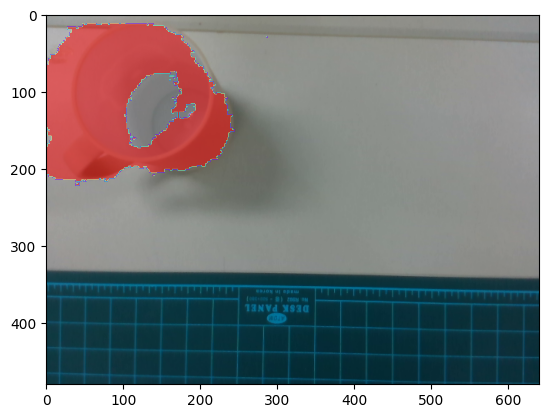

Visualizing...takes time


In [37]:
local_regions = True #False
filter_grasps = True #False
skip_border_objects = True
forward_passes = 1
z_range = [0.2, 1.0]

pc_segments = {}
pc_full = None
pc_colors = None

rospy.sleep(0.5)
rgb, depth = get_frames(pipeline)
# rgb, depth = get_view(ROBOT_INIT_POS, grasp=0.0, show_img=True)
segmap = (depth<0.34) #None

if segmap is None and (local_regions or filter_grasps):
    raise ValueError('Need segmentation map to extract local regions or filter grasps')

if pc_full is None:
    print('Converting depth to point cloud(s)...')
    pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(depth, K_rs, segmap=segmap, rgb=rgb,
                                                        skip_border_objects=skip_border_objects, z_range=z_range)

#visualize_grasps(pc_full, [], [], plot_opencv_cam=True, pc_colors=pc_colors)
#input("continue?")

print('Generating Grasps...')
pred_grasps_cam, scores, contact_pts, _ = grasp_estimator.predict_scene_grasps(sess, pc_full,
                                pc_segments=pc_segments, local_regions=local_regions,
                                filter_grasps=filter_grasps, forward_passes=forward_passes)

print(pred_grasps_cam)
print(contact_pts)

# Visualize results
show_image(rgb, segmap)
visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=True, pc_colors=pc_colors)

In [13]:
pred_grasps_cam[-1].shape

(200, 4, 4)

In [16]:
pred_grasps_cam[-1][0]

array([[ 0.88332707,  0.46369854,  0.06867979,  0.19373299],
       [-0.23959601,  0.3206932 ,  0.91637856, -0.35752958],
       [ 0.40289822, -0.8259174 ,  0.39437732,  0.8100216 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [14]:
scores

{-1: array([0.30147088, 0.45301533, 0.32667193, 0.2912303 , 0.2667172 ,
        0.6157515 , 0.25125158, 0.25103498, 0.24447437, 0.28121218,
        0.33686197, 0.6603194 , 0.45286596, 0.6725296 , 0.32239753,
        0.37325004, 0.30675837, 0.4312917 , 0.26645344, 0.43496612,
        0.64028233, 0.42453545, 0.6233985 , 0.5084214 , 0.5867879 ,
        0.61812484, 0.6048351 , 0.36314997, 0.6191297 , 0.45495123,
        0.40340233, 0.62787807, 0.7066338 , 0.251157  , 0.6143067 ,
        0.5762971 , 0.24927138, 0.64816236, 0.26237735, 0.63706017,
        0.47214544, 0.3092052 , 0.25727928, 0.28147104, 0.5976863 ,
        0.24987769, 0.23501445, 0.6455638 , 0.527955  , 0.6012448 ,
        0.24123055, 0.26061127, 0.67251426, 0.63230634, 0.4882633 ,
        0.2554751 , 0.501368  , 0.56751096, 0.29575595, 0.30565673,
        0.28119564, 0.4010619 , 0.29835817, 0.65717924, 0.7141953 ,
        0.6923127 , 0.6609204 , 0.24676137, 0.6305476 , 0.37592304,
        0.62376416, 0.28871474, 0.29146308, 

In [11]:
visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=True, pc_colors=pc_colors)

Visualizing...takes time


In [10]:
mlab.init_notebook(backend='x3d')

Notebook initialized with x3d backend.


In [ ]:
def move_to_pick(grasp):
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)
    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(grasp))
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    goal_rotation = T_base_to_goal[:3, :3]
    return goal_position, goal_rotation
    #_ = get_view(goal_position)

In [19]:
pred_grasps_cam[-1].shape

(15, 4, 4)

In [21]:
contact_pts[-1].shape

(15, 3)

In [22]:
pred_grasps_cam[-1][0]

array([[ 0.41862294,  0.40436792,  0.8131675 , -0.38740396],
       [-0.5746213 , -0.5754342 ,  0.5819672 , -0.2503978 ],
       [ 0.70325327, -0.7108882 , -0.00853152,  0.5782789 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [23]:
contact_pts[-1][0]

array([-0.30415386, -0.18908113,  0.576     ], dtype=float32)

In [24]:
scores

{-1: array([0.21514384, 0.27907804, 0.31374398, 0.25334188, 0.21320555,
        0.19859609, 0.28140017, 0.23026608, 0.26156896, 0.286949  ,
        0.18190922, 0.2528776 , 0.18458149, 0.2645106 , 0.23406237],
       dtype=float32)}

In [26]:
grasp = pred_grasps_cam[-1][0].copy()

In [ ]:
P = 

In [29]:
grasp

array([[ 0.41862294,  0.40436792,  0.8131675 , -0.38740396],
       [-0.5746213 , -0.5754342 ,  0.5819672 , -0.2503978 ],
       [ 0.70325327, -0.7108882 , -0.00853152,  0.5782789 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [28]:
inverse_projection(depth, np.array([240, 240]), K_rs, D_rs)

array([-0.07619607, -0.00388725,  0.566     ])

In [33]:
# eef to realsense offset
T_eef_to_rs = np.load('rs_extrinsic.npy')

In [34]:
T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)
T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(grasp))    

In [35]:
T_base_to_goal

array([[ 0.34815591,  0.39613383,  0.84962665, -0.41787449],
       [ 0.61477451,  0.58773438, -0.52594731, -0.13293432],
       [-0.70770032,  0.70544048, -0.03890979,  0.23799978],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [7]:
ROBOT_INIT_POS = [0.0, -0.3, 0.65]
ROBOT_INIT_ROTATION = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])